In [26]:
import os
import random

import numpy as np
import cv2
import tensorflow as tf
import pywt
from tensorflow import keras

import matplotlib.pyplot as plt

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [27]:
image_size = 128
# train_path = "dataset/stage1_train/"
train_path = "train"
epochs = 1000
batch_size = 8

train_ids = next(os.walk(train_path))[1]
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class CustomPoolingLayer(Layer):
    def __init__(self, call_function, compute_output_shape_function=None, **kwargs):
        super(CustomPoolingLayer, self).__init__(**kwargs)
        self._call_function = call_function
        self._compute_output_shape_function = compute_output_shape_function

    def call(self, inputs, training=None):
        return self._call_function(inputs)

    def compute_output_shape(self, input_shape):
        if self._compute_output_shape_function:
            return self._compute_output_shape_function(input_shape)
        else:
            # If compute_output_shape_function is not provided, infer output shape from the call function
            output_shape = self._call_function(tf.zeros(input_shape))
            return output_shape.shape

    def get_config(self):
        config = super(CustomPoolingLayer, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [29]:
import cv2
import pywt
import numpy as np
def wavelet_pooling(inputs):
    image = inputs
    # image_size = 128
    # image_path = "new.png"

    # image = cv2.imread(image_path, 1)
    # image = cv2.resize(image, (image_size, image_size))
    # print(image.shape)

    LL_channels = []
    for channel in range(image.shape[2]):
        coeffs = pywt.dwt2(image[:, :, channel], 'haar')
        LL, (_, _, _) = coeffs
        LL_channels.append(LL)

    # Stack LL coefficients from each channel to reconstruct the LL coefficient image
    LL_image = np.stack(LL_channels, axis=-1)

    return LL_image
    # image = cv2.resize(image, (64, 64))
    # image = np.concatenate([image, image[:, :, 1:2]], axis=-1)

    # cv2.imshow("Image", image)

    # print(image.shape)

In [30]:
WaveletPooling2D = CustomPoolingLayer(call_function=wavelet_pooling)

## 1.2 Advantages
<h3> Advantages: </h3>
<ol>
    <li>The UNet combines the location information from the downsampling path to finally obtain a general information combining localisation and context, which is necessary to predict a good segmentation map.</li>
    <li>No Dense layer is used, so image sizes can be used.</li>
</ol>

In [31]:
WaveletPooling2D = CustomPoolingLayer(call_function=wavelet_pooling)
WaveletPooling2D = keras.layers.MaxPool2D

## Data Generator

In [32]:
class DataBatchGenerator(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        # Read and preprocess the image
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
        
        # Apply wavelet transformation (Haar wavelet)
        coeffs = pywt.dwt2(image, 'haar')
        LL, (LH, HL, HH) = coeffs
        image = LL
        
        image = np.reshape(image, (image.shape[0], image.shape[1], -1))
    
        image = cv2.resize(image, (128, 128))
        image = np.concatenate([image, image[:, :, 1:2]], axis=-1)
        image = image / 255.0
        mask = mask / 255.0
        
        return image, mask
        
            
    
    
    def __getitem__(self, index):
        # Load data for a batch
        if (index + 1) * self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size
        
        files_batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
        
        image = []
        mask = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids) / float(self.batch_size)))

train_gen = DataBatchGenerator(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataBatchGenerator(valid_ids, train_path, image_size=image_size, batch_size=batch_size)


In [33]:
gen = DataBatchGenerator(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


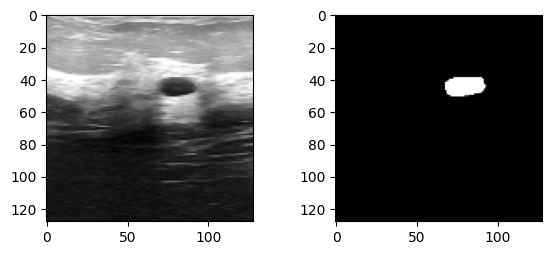

In [34]:

r = random.randint(0, len(x)-1)

# Generate a random index
r = random.randint(0, len(x)-1)

# Create a figure and subplots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot the original image
ax = fig.add_subplot(1, 2, 1)
# Since the image has been transformed by wavelet, we may need to reshape it
# For example, if LL is the transformed image, we can plot it like this:
# ax.imshow(x[r], cmap='gray')  # Assuming the transformed image is grayscale
# Assuming the transformed image has a shape of (128, 64, 3) after wavelet transformation
ax.imshow(x[r][:, :, 0], cmap='gray')  # Display the first channel of the RGB image as grayscale

# If LL is a multi-channel image, we need to select one channel for display

# Plot the corresponding mask
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")  # Assuming y contains masks


## Different Convolutional Blocks

In [35]:
# def contraction_path(x, filters, kernel_size=(3, 3), padding="same", strides=1):
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     p = WaveletPooling2D((2, 2), (2, 2))(c)
#     return c, p

# def expansive_path(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
#     us = keras.layers.UpSampling2D((2, 2))(x)
#     concat = keras.layers.Concatenate()([us, skip])
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     return c

# def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     return c

In [36]:
# def contraction_path(x, filters, kernel_size=(3, 3), padding="same", strides=1):
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
#     return c, p

# def expansive_path(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
#     us = keras.layers.UpSampling2D((2, 2))(x)
#     concat = keras.layers.Concatenate()([us, skip])
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     return c

# def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     return c

## UNet Model

In [37]:
# def UNet():
#     f = [16, 32, 64, 128, 256]
#     inputs = keras.layers.Input((image_size, image_size, 3))
    
#     p0 = inputs
#     c1, p1 = contraction_path(p0, f[0]) #128 -> 64
#     c2, p2 = contraction_path(p1, f[1]) #64 -> 32
#     c3, p3 = contraction_path(p2, f[2]) #32 -> 16
#     c4, p4 = contraction_path(p3, f[3]) #16->8
    
#     bn = bottleneck(p4, f[4])
    
#     u1 = expansive_path(bn, c4, f[3]) #8 -> 16
#     u2 = expansive_path(u1, c3, f[2]) #16 -> 32
#     u3 = expansive_path(u2, c2, f[1]) #32 -> 64
#     u4 = expansive_path(u3, c1, f[0]) #64 -> 128
    
#     outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
#     model = keras.models.Model(inputs, outputs)
#     return model

In [38]:
# model = UNet()
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
# model.summary()

In [39]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.models import Model

def build_model():
    # Define input layer
    inputs = Input(shape=(128, 128, 3), name='input_layer')

    # Define convolutional layers
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2d_76')(inputs)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2d_77')(conv1)
    pool1 = MaxPooling2D((2, 2), name='max_pooling2d_16')(conv2)

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_78')(pool1)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_79')(conv3)
    pool2 = MaxPooling2D((2, 2), name='max_pooling2d_17')(conv4)

    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_80')(pool2)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_81')(conv5)
    pool3 = MaxPooling2D((2, 2), name='max_pooling2d_18')(conv6)

    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_82')(pool3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_83')(conv7)
    pool4 = MaxPooling2D((2, 2), name='max_pooling2d_19')(conv8)

    conv9 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv2d_84')(pool4)
    conv10 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv2d_85')(conv9)

    # Define upsampling layers
    up1 = UpSampling2D((2, 2), name='up_sampling2d_16')(conv10)
    concat1 = Concatenate(axis=-1, name='concatenate_16')([up1, conv8])
    conv11 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_86')(concat1)
    conv12 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_87')(conv11)

    up2 = UpSampling2D((2, 2), name='up_sampling2d_17')(conv12)
    concat2 = Concatenate(axis=-1, name='concatenate_17')([up2, conv6])
    conv13 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_88')(concat2)
    conv14 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d_89')(conv13)

    up3 = UpSampling2D((2, 2), name='up_sampling2d_18')(conv14)
    concat3 = Concatenate(axis=-1, name='concatenate_18')([up3, conv4])
    conv15 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_90')(concat3)
    conv16 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_91')(conv15)

    up4 = UpSampling2D((2, 2), name='up_sampling2d_19')(conv16)
    concat4 = Concatenate(axis=-1, name='concatenate_19')([up4, conv2])
    conv17 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2d_92')(concat4)
    conv18 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2d_93')(conv17)

    output = Conv2D(1, (1, 1), activation='sigmoid', name='conv2d_94')(conv18)

    # Create model
    model = Model(inputs=inputs, outputs=output)

    return model

# Build the model
model = build_model()

model.load_weights("unet_1k_epochs_MIOS.weights.h5")

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

# Print model summary
model.summary()


ValueError: Layer 'conv2d_76' expected 2 variables, but received 0 variables during loading. Expected: ['conv2d_76/kernel:0', 'conv2d_76/bias:0']

## Training the model

In [ ]:
train_gen = DataBatchGenerator(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataBatchGenerator(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=int(train_steps), validation_steps=int(valid_steps), 
                    epochs=epochs)

Epoch 1/1000


44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - acc: 0.8964 - loss: 0.3921 - val_acc: 0.9561 - val_loss: 0.1221
Epoch 2/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.9548 - loss: 0.1546 - val_acc: 0.9679 - val_loss: 0.1252
Epoch 3/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - acc: 0.9479 - loss: 0.1886 - val_acc: 0.9189 - val_loss: 0.2507
Epoch 4/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9398 - loss: 0.2407 - val_acc: 0.9866 - val_loss: 0.0706
Epoch 5/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - acc: 0.9468 - loss: 0.2001 - val_acc: 0.9790 - val_loss: 0.0981
Epoch 6/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - acc: 0.9498 - loss: 0.3197 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - acc: 0.9518 - loss: 0.2334 - val_acc: 0.9561 - val_loss: 0.1704
Epoch 8/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - acc: 0.9495 - loss: 0.2599 - val_acc: 0.9679 - val_loss: 0.2000
Epoch 9/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

## Testing the model

In [ ]:
print(valid_gen.__getitem__(1))

(array([[[[0.74117647, 0.74117647, 0.74117647],
         [0.95098039, 0.95098039, 0.95098039],
         [1.37058824, 1.37058824, 1.37058824],
         ...,
         [1.34901961, 1.34901961, 1.34901961],
         [1.02745098, 1.02745098, 1.02745098],
         [0.86666667, 0.86666667, 0.86666667]],

        [[1.11764706, 1.11764706, 1.11764706],
         [1.22647059, 1.22647059, 1.22647059],
         [1.44411765, 1.44411765, 1.44411765],
         ...,
         [1.14705882, 1.14705882, 1.14705882],
         [1.0254902 , 1.0254902 , 1.0254902 ],
         [0.96470588, 0.96470588, 0.96470588]],

        [[1.1372549 , 1.1372549 , 1.1372549 ],
         [1.1872549 , 1.1872549 , 1.1872549 ],
         [1.2872549 , 1.2872549 , 1.2872549 ],
         ...,
         [1.01960784, 1.01960784, 1.01960784],
         [1.11372549, 1.11372549, 1.11372549],
         [1.16078431, 1.16078431, 1.16078431]],

        ...,

        [[0.21960784, 0.21960784, 0.21960784],
         [0.22254902, 0.22254902, 0.22254902

In [ ]:
x_batch, y_batch = valid_gen.__getitem__(4)

batch_accuracy = 0
results_batch = model.predict(x_batch)
results_batch = results_batch > 0.5
batch_accuracy=np.mean(results_batch == y_batch)
print(batch_accuracy*100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
98.1597900390625


In [ ]:
model.save_weights("UNet.weights.h5")

x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


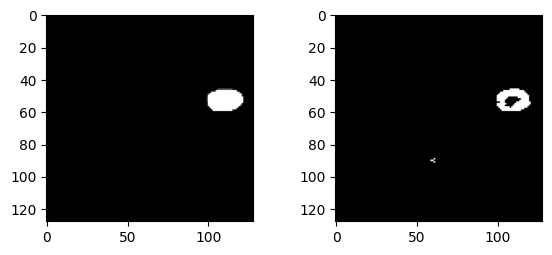

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")